<a href="https://colab.research.google.com/github/SamudiniD/Efficient-Denoising-for-single-band-astronomical-images/blob/main/Data_Exploratory_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split

# ✅ Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# ✅ Change base directory to Google Drive
base_dir = "/content/drive/MyDrive/sdss_image_dataset"
sub_dirs = ["train", "test", "val"]

# ✅ Create folder hierarchy in Drive
for sub in sub_dirs:
    os.makedirs(os.path.join(base_dir, sub, "noisy"), exist_ok=True)
    os.makedirs(os.path.join(base_dir, sub, "clean"), exist_ok=True)

# ✅ Load CSV and filter unique rows
csv_path = "/content/Skyserver_4.csv"  # CSV should also be in Drive
df = pd.read_csv ("/content/Skyserver_4.csv")
df_filtered = df.drop_duplicates(subset=["run", "rerun", "camcol", "field"])

# ✅ Select 2000 random samples
df_filtered = df_filtered.sample(n=1500, random_state=42)

# Split 80% Train, 20% (to be split further into Validation & Test)
train, temp = train_test_split(df_filtered, test_size=0.2, random_state=42)

# Split the remaining 20% equally into Validation (10%) and Test (10%)
val, test = train_test_split(temp, test_size=0.5, random_state=42)

# Print dataset sizes
print("Train Set:", train.shape)   # 1600 rows (80%)
print("Validation Set:", val.shape)  # 200 rows (10%)
print("Test Set:", test.shape)    # 200 rows (10%)

# ✅ Function to download FITS files
def download_fits(row, dataset_type):
    run, rerun, camcol, field = row["run"], row["rerun"], row["camcol"], row["field"]

    for band, subfolder in zip(["u", "r"], ["noisy", "clean"]):  # u-band = noisy, r-band = clean
        filename = os.path.join(base_dir, dataset_type, subfolder, f"frame-{band}-{run}-{camcol}-{field}.fits.bz2")

        # ✅ Skip if already downloaded
        if os.path.exists(filename):
            print(f"🔹 Skipping (Already Exists): {filename}")
            continue

        # ✅ Construct FITS URL
        fits_url = f"https://data.sdss.org/sas/dr16/eboss/photoObj/frames/{rerun}/{run}/{camcol}/frame-{band}-{run:06d}-{camcol}-{field:04d}.fits.bz2"

        response = requests.get(fits_url, stream=True)

        if response.status_code == 200:
            with open(filename, "wb") as file:
                for chunk in response.iter_content(chunk_size=1024):
                    file.write(chunk)
            print(f"✅ Saved to Google Drive: {filename}")
        else:
            print(f"❌ Failed: {fits_url}")

# ✅ Start downloading and saving to Drive
for _, row in df_filtered.iterrows():
    dataset_type = row["dataset_type"]
    download_fits(row, dataset_type)

print("✅ All downloads complete and permanently saved in Google Drive!")


Mounted at /content/drive


FileNotFoundError: [Errno 2] No such file or directory: '/content/Skyserver_4.csv'

In [ ]:
import bz2
import shutil
import os

# Base directory where FITS files are stored
base_dir = "/content/drive/MyDrive/sdss_2000_dataset"

# ✅ Function to decompress .bz2 FITS files and delete compressed files
def decompress_fits(fits_bz2_path, output_path):
    try:
        # Open the compressed .bz2 file and save it as an uncompressed .fits file
        with bz2.BZ2File(fits_bz2_path, "rb") as file, open(output_path, "wb") as out_file:
            shutil.copyfileobj(file, out_file)

        print(f"✅ Decompressed: {output_path}")

        # ✅ Delete the original .bz2 file after successful decompression
        os.remove(fits_bz2_path)
        print(f"🗑️ Deleted: {fits_bz2_path}")

    except Exception as e:
        print(f"❌ Error decompressing {fits_bz2_path}: {e}")

# ✅ Loop through all dataset subsets and categories
for sub in ["train", "test", "val"]:  # Loop through dataset splits
    for category in ["noisy", "clean"]:  # Loop through 'noisy' and 'clean'
        folder_path = os.path.join(base_dir, sub, category)  # Full folder path
        for file in os.listdir(folder_path):  # List all files
            if file.endswith(".bz2"):  # Only process .bz2 files
                fits_bz2_path = os.path.join(folder_path, file)  # Full path of .bz2 file
                output_path = fits_bz2_path.replace(".fits.bz2", ".fits")  # Define output .fits file
                decompress_fits(fits_bz2_path, output_path)  # Call decompression function

print("✅ All FITS files decompressed, and .bz2 files deleted!")


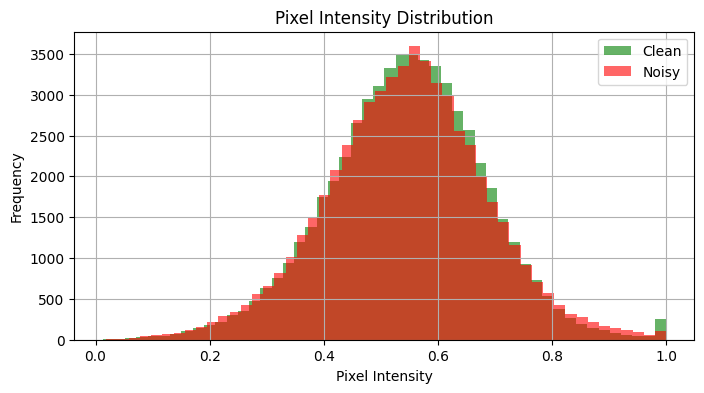

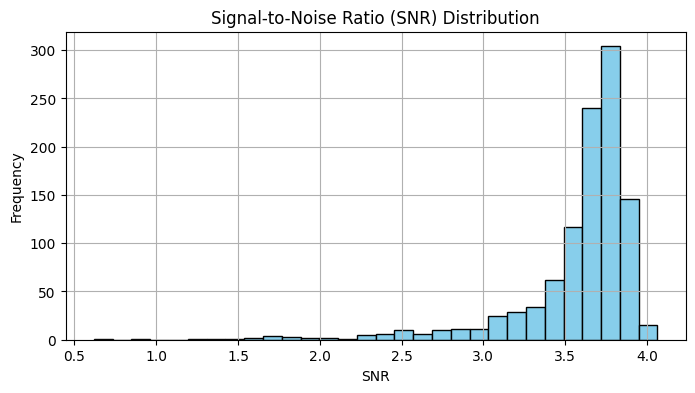

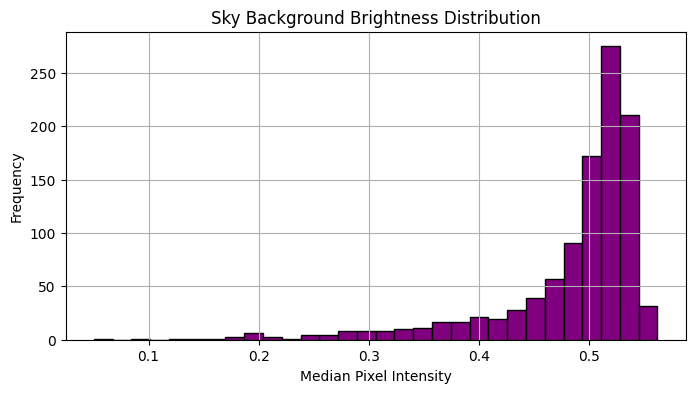

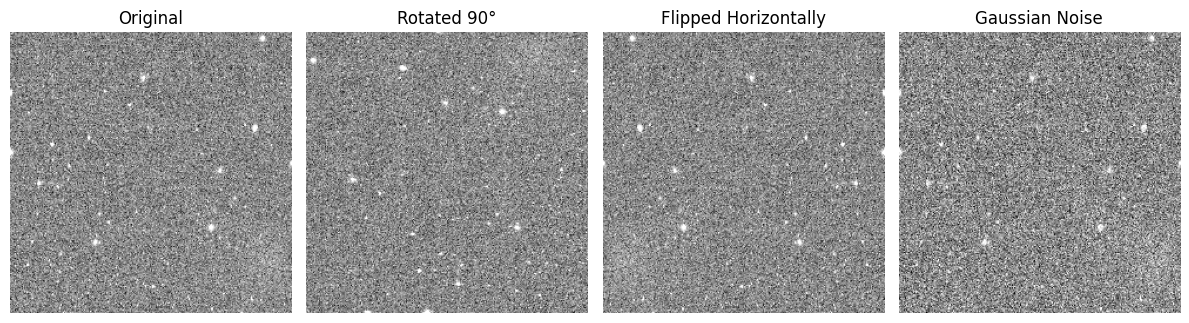

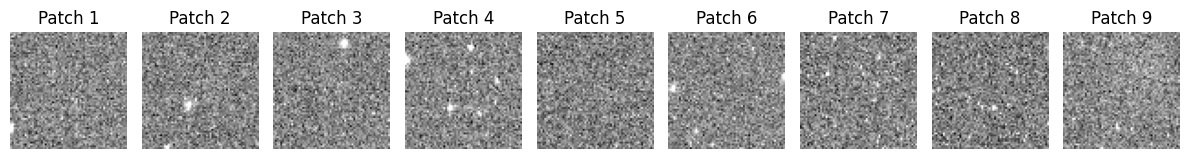

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Paths to your dataset
train_clean_path = "/content/drive/MyDrive/SDSS_augmented_npy/train/clean.npy"
train_noisy_path = "/content/drive/MyDrive/SDSS_augmented_npy/train/noisy.npy"

# Load datasets
clean_images = np.load(train_clean_path).astype('float32')
noisy_images = np.load(train_noisy_path).astype('float32')

# Normalize if not already in [0,1]
if clean_images.max() > 1.0:
    clean_images /= 255.
if noisy_images.max() > 1.0:
    noisy_images /= 255.

# -------------------------------
# 1. Pixel Intensity Histogram (Clean vs Noisy)
# -------------------------------
def plot_pixel_histograms():
    plt.figure(figsize=(8, 4))
    plt.hist(clean_images[0].flatten(), bins=50, alpha=0.6, label="Clean", color='green')
    plt.hist(noisy_images[0].flatten(), bins=50, alpha=0.6, label="Noisy", color='red')
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.title("Pixel Intensity Distribution")
    plt.legend()
    plt.grid(True)
    plt.show()

# -------------------------------
# 2. SNR Histogram
# -------------------------------
def plot_snr_distribution():
    snr = [np.mean(img) / (np.std(img) + 1e-8) for img in clean_images]
    plt.figure(figsize=(8, 4))
    plt.hist(snr, bins=30, color='skyblue', edgecolor='black')
    plt.title("Signal-to-Noise Ratio (SNR) Distribution")
    plt.xlabel("SNR")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

# -------------------------------
# 3. Sky Background (Median) Histogram
# -------------------------------
def plot_background_distribution():
    background_levels = [np.median(img) for img in clean_images]
    plt.figure(figsize=(8, 4))
    plt.hist(background_levels, bins=30, color='purple', edgecolor='black')
    plt.title("Sky Background Brightness Distribution")
    plt.xlabel("Median Pixel Intensity")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

# -------------------------------
# 4. Augmentation Visualization
# -------------------------------
def visualize_augmentations():
    from skimage.util import random_noise
    from skimage.transform import rotate

    img = clean_images[0]
    rotated = rotate(img, 90)
    flipped = np.fliplr(img)
    gaussian_noised = random_noise(img, mode='gaussian', mean=0, var=0.01)

    plt.figure(figsize=(12, 4))
    titles = ['Original', 'Rotated 90°', 'Flipped Horizontally', 'Gaussian Noise']
    images = [img, rotated, flipped, gaussian_noised]

    for i, (title, im) in enumerate(zip(titles, images)):
        plt.subplot(1, 4, i+1)
        plt.imshow(im, cmap='gray')
        plt.title(title)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# -------------------------------
# 5. Patch Visualization (64x64 from 240x240)
# -------------------------------
def visualize_patches():
    img_240 = clean_images[0]
    patches = [img_240[i:i+64, j:j+64] for i in range(0, 177, 88) for j in range(0, 177, 88)]

    plt.figure(figsize=(12, 4))
    for idx, patch in enumerate(patches):
        plt.subplot(1, len(patches), idx + 1)
        plt.imshow(patch, cmap='gray')
        plt.title(f'Patch {idx+1}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Call the visualizations one by one
plot_pixel_histograms()
plot_snr_distribution()
plot_background_distribution()
visualize_augmentations()
visualize_patches()


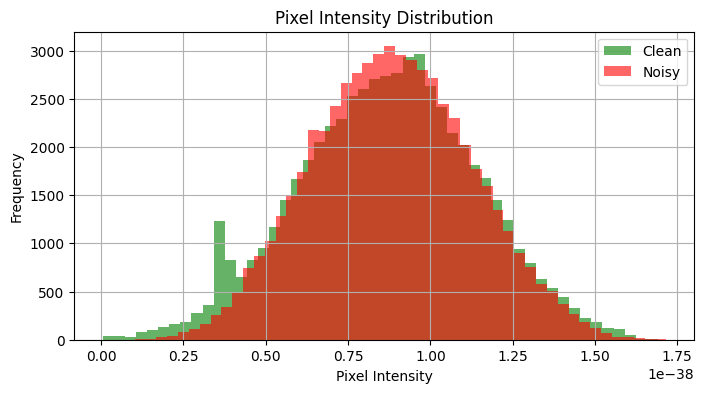

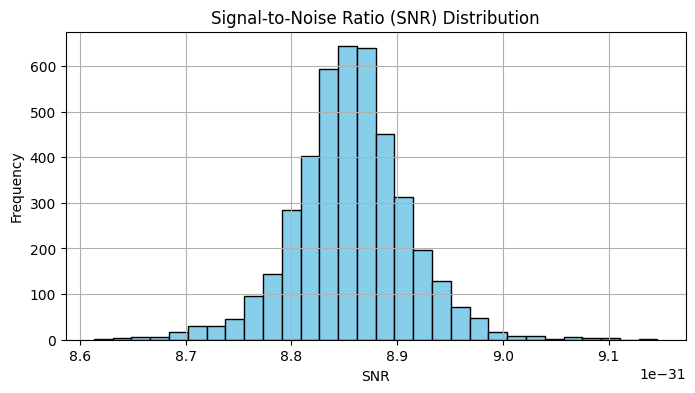

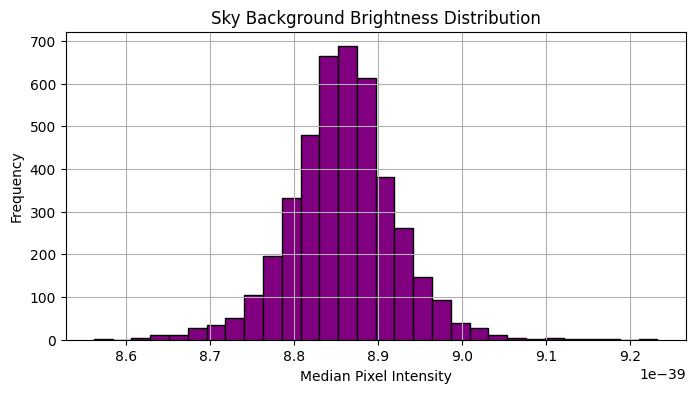

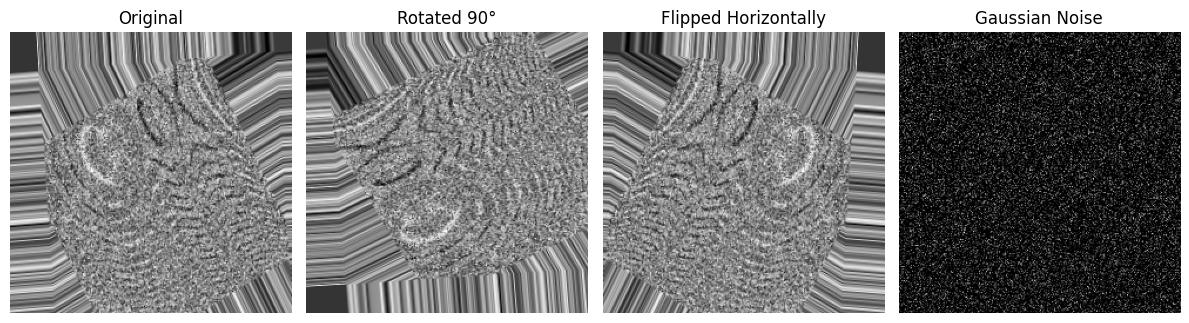

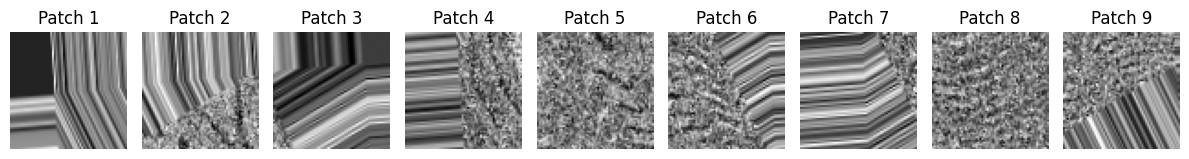

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Paths to your dataset
train_clean_path = "/content/drive/MyDrive/sdss_image_dataset/augmented/npy/train_clean_full.npy"
train_noisy_path = "/content/drive/MyDrive/sdss_image_dataset/augmented/npy/train_noisy_full.npy"

# Load datasets
clean_images = np.load(train_clean_path).astype('float32')
noisy_images = np.load(train_noisy_path).astype('float32')

# Normalize if not already in [0,1]
if clean_images.max() > 1.0:
    clean_images /= 255.
if noisy_images.max() > 1.0:
    noisy_images /= 255.

# -------------------------------
# 1. Pixel Intensity Histogram (Clean vs Noisy)
# -------------------------------
def plot_pixel_histograms():
    plt.figure(figsize=(8, 4))
    plt.hist(clean_images[0].flatten(), bins=50, alpha=0.6, label="Clean", color='green')
    plt.hist(noisy_images[0].flatten(), bins=50, alpha=0.6, label="Noisy", color='red')
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.title("Pixel Intensity Distribution")
    plt.legend()
    plt.grid(True)
    plt.show()

# -------------------------------
# 2. SNR Histogram
# -------------------------------
def plot_snr_distribution():
    snr = [np.mean(img) / (np.std(img) + 1e-8) for img in clean_images]
    plt.figure(figsize=(8, 4))
    plt.hist(snr, bins=30, color='skyblue', edgecolor='black')
    plt.title("Signal-to-Noise Ratio (SNR) Distribution")
    plt.xlabel("SNR")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

# -------------------------------
# 3. Sky Background (Median) Histogram
# -------------------------------
def plot_background_distribution():
    background_levels = [np.median(img) for img in clean_images]
    plt.figure(figsize=(8, 4))
    plt.hist(background_levels, bins=30, color='purple', edgecolor='black')
    plt.title("Sky Background Brightness Distribution")
    plt.xlabel("Median Pixel Intensity")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

# -------------------------------
# 4. Augmentation Visualization
# -------------------------------
def visualize_augmentations():
    from skimage.util import random_noise
    from skimage.transform import rotate

    img = clean_images[0]
    rotated = rotate(img, 90)
    flipped = np.fliplr(img)
    gaussian_noised = random_noise(img, mode='gaussian', mean=0, var=0.01)

    plt.figure(figsize=(12, 4))
    titles = ['Original', 'Rotated 90°', 'Flipped Horizontally', 'Gaussian Noise']
    images = [img, rotated, flipped, gaussian_noised]

    for i, (title, im) in enumerate(zip(titles, images)):
        plt.subplot(1, 4, i+1)
        plt.imshow(im, cmap='gray')
        plt.title(title)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# -------------------------------
# 5. Patch Visualization (64x64 from 240x240)
# -------------------------------
def visualize_patches():
    img_240 = clean_images[0]
    patches = [img_240[i:i+64, j:j+64] for i in range(0, 177, 88) for j in range(0, 177, 88)]

    plt.figure(figsize=(12, 4))
    for idx, patch in enumerate(patches):
        plt.subplot(1, len(patches), idx + 1)
        plt.imshow(patch, cmap='gray')
        plt.title(f'Patch {idx+1}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Call the visualizations one by one
plot_pixel_histograms()
plot_snr_distribution()
plot_background_distribution()
visualize_augmentations()
visualize_patches()



---
Folder: noisy (single_shot)  (/content/drive/MyDrive/PS1_Dataset/single_shot)
---

File: rings-warp-1.fits
Filename: /content/drive/MyDrive/PS1_Dataset/single_shot/rings-warp-1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1  COMPRESSED_IMAGE    1 CompImageHDU    125   (6291, 6247)   int16 (rescales to float32)   
  SIMPLE   = True
  BITPIX   = 16
  NAXIS    = 0

---
Folder: clean (stack)  (/content/drive/MyDrive/PS1_Dataset/stack)
---

File: rings-stk-1.fits
Filename: /content/drive/MyDrive/PS1_Dataset/stack/rings-stk-1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1  COMPRESSED_IMAGE    1 CompImageHDU    256   (6291, 6247)   int16 (rescales to float32)   
  SIMPLE   = True
  BITPIX   = 16
  NAXIS    = 0


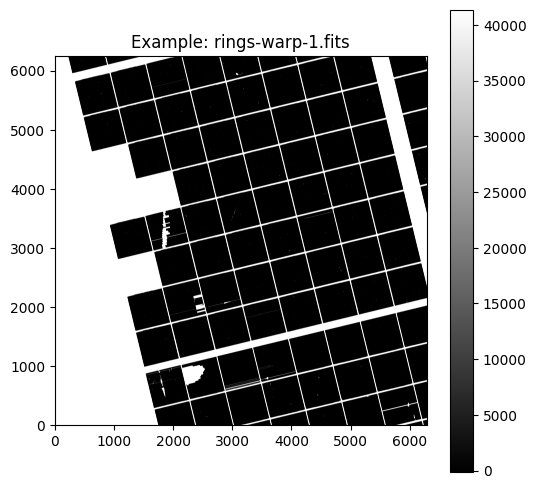

In [ ]:

import os
from astropy.io import fits
import matplotlib.pyplot as plt

# adjust these paths to your actual dataset locations
folders = {
    'noisy (single_shot)': '/content/drive/MyDrive/PS1_Dataset/single_shot',
    'clean (stack)'      : '/content/drive/MyDrive/PS1_Dataset/stack'
}

for desc, folder in folders.items():
    print(f"\n---\nFolder: {desc}  ({folder})\n---")
    for fname in sorted(os.listdir(folder)):
        if not fname.lower().endswith('.fits'):
            continue
        path = os.path.join(folder, fname)
        with fits.open(path) as hdul:
            print(f"\nFile: {fname}")
            # HDU summary
            hdul.info()

            # print a handful of key header cards from the primary HDU
            hdr = hdul[0].header
            for key in ('SIMPLE','BITPIX','NAXIS','FILTER','EXPTIME','DATE-OBS','OBJECT'):
                if key in hdr:
                    print(f"  {key:8s} = {hdr[key]}")
            # stop after first file in each folder
            break

# Optional: Display the first image from the noisy folder
example = os.path.join(folders['noisy (single_shot)'], os.listdir(folders['noisy (single_shot)'])[0])
with fits.open(example) as hdul:
    data = hdul[1].data  # adjust if your image is in HDU1
plt.figure(figsize=(6,6))
plt.imshow(data, cmap='gray', origin='lower')
plt.colorbar()
plt.title(f"Example: {os.path.basename(example)}")
plt.show()


In [ ]:
import os
from collections import Counter

def count_file_types(folder_path):
    """
    Scans the given folder (non-recursively) and returns a Counter
    mapping file extensions to their counts.
    """
    counts = Counter()
    for entry in os.scandir(folder_path):
        if entry.is_file():
            ext = os.path.splitext(entry.name)[1].lower().lstrip('.')
            if not ext:
                ext = '<no_ext>'
            counts[ext] += 1
    return counts

if __name__ == "__main__":
    # 🔧 Set your path here:
    path = "/content/drive/MyDrive/SDSS_augmented_npy/val/noisy"

    if not os.path.isdir(path):
        print(f"❌ Path does not exist or is not a directory: {path}")
    else:
        result = count_file_types(path)
        total = sum(result.values())
        print(f"\nScanned {total} files in {path!r}\n")
        print("Extension │ Count")
        print("----------┼-------")
        for ext, cnt in result.most_common():
            print(f"{ext:>8} │ {cnt}")



Scanned 666 files in '/content/drive/MyDrive/SDSS_augmented_npy/val/noisy'

Extension │ Count
----------┼-------
     npy │ 666


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
import os

# Paths to your clean and noisy FITS directories
CLEAN_DIR = "/content/drive/MyDrive/sdss_image_dataset/train/clean"
NOISY_DIR = "/content/drive/MyDrive/sdss_image_dataset/train/noisy"

# List and sort filenames to keep output deterministic
clean_files = sorted(f for f in os.listdir(CLEAN_DIR) if f.lower().endswith(".fits"))

print("Checking paired FITS files:\n")

for clean_fname in clean_files:
    # Derive the noisy filename by swapping '-r-' → '-u-'
    noisy_fname = clean_fname.replace("-r-", "-u-")

    clean_path = os.path.join(CLEAN_DIR, clean_fname)
    noisy_path = os.path.join(NOISY_DIR, noisy_fname)

    if os.path.isfile(noisy_path):
        print(f"✅ Paired: {clean_fname}  ↔  {noisy_fname}")
    else:
        print(f"❌ No pair for: {clean_fname}")

# Optionally, to find any noisy files without a matching clean:
print("\nChecking for noisy FITS without a clean pair:\n")

noisy_files = sorted(f for f in os.listdir(NOISY_DIR) if f.lower().endswith(".fits"))
for noisy_fname in noisy_files:
    clean_fname = noisy_fname.replace("-u-", "-r-")
    if not os.path.isfile(os.path.join(CLEAN_DIR, clean_fname)):
        print(f"❌ No pair for: {noisy_fname}")


Checking paired FITS files:

✅ Paired: frame-r-1035-1-103.fits  ↔  frame-u-1035-1-103.fits
✅ Paired: frame-r-1035-1-104.fits  ↔  frame-u-1035-1-104.fits
✅ Paired: frame-r-1035-1-108.fits  ↔  frame-u-1035-1-108.fits
✅ Paired: frame-r-1035-1-109.fits  ↔  frame-u-1035-1-109.fits
✅ Paired: frame-r-1035-1-111.fits  ↔  frame-u-1035-1-111.fits
✅ Paired: frame-r-1035-1-112.fits  ↔  frame-u-1035-1-112.fits
✅ Paired: frame-r-1035-1-113.fits  ↔  frame-u-1035-1-113.fits
✅ Paired: frame-r-1035-1-116.fits  ↔  frame-u-1035-1-116.fits
✅ Paired: frame-r-1035-1-117.fits  ↔  frame-u-1035-1-117.fits
✅ Paired: frame-r-1035-1-121.fits  ↔  frame-u-1035-1-121.fits
✅ Paired: frame-r-1035-1-122.fits  ↔  frame-u-1035-1-122.fits
✅ Paired: frame-r-1035-1-123.fits  ↔  frame-u-1035-1-123.fits
✅ Paired: frame-r-1035-1-131.fits  ↔  frame-u-1035-1-131.fits
✅ Paired: frame-r-1035-1-132.fits  ↔  frame-u-1035-1-132.fits
✅ Paired: frame-r-1035-1-133.fits  ↔  frame-u-1035-1-133.fits
✅ Paired: frame-r-1035-1-135.fits  ↔  fra

In [ ]:
import os
import shutil
import numpy as np
from astropy.io import fits

BASE_DIR   = "/content/drive/MyDrive/sdss_image_dataset/train"
CLEAN_IN   = os.path.join(BASE_DIR, "clean")
NOISY_IN   = os.path.join(BASE_DIR, "noisy")
AUG_BASE   = "/content/drive/MyDrive/sdss_image_dataset/augment_set3"
CLEAN_OUT  = os.path.join(AUG_BASE, "clean")
NOISY_OUT  = os.path.join(AUG_BASE, "noisy")
ROT_ANGLES = [90, 180, 270]

# clear & recreate output folders
for d in (CLEAN_OUT, NOISY_OUT):
    if os.path.isdir(d):
        shutil.rmtree(d)
    os.makedirs(d, exist_ok=True)

for clean_fname in os.listdir(CLEAN_IN):
    if not clean_fname.lower().endswith(".fits"):
        continue

    noisy_fname = clean_fname.replace("frame-r-", "frame-u-")
    clean_src   = os.path.join(CLEAN_IN, clean_fname)
    noisy_src   = os.path.join(NOISY_IN, noisy_fname)

    # ensure both files exist before loading
    if not os.path.isfile(noisy_src):
        print(f"⚠️  Missing pair for {clean_fname}, skipping.")
        continue

    try:
        clean_data = fits.getdata(clean_src)
        noisy_data = fits.getdata(noisy_src)
    except Exception as e:
        print(f"❌  Failed to read pair {clean_fname} / {noisy_fname}: {e}")
        continue

    base_c = os.path.splitext(clean_fname)[0]
    base_n = os.path.splitext(noisy_fname)[0]

    for angle in ROT_ANGLES:
        k = angle // 90
        clean_rot = np.rot90(clean_data, k=k)
        noisy_rot = np.rot90(noisy_data, k=k)

        fits.writeto(os.path.join(CLEAN_OUT,  f"{base_c}_rot{angle}.fits"),
                     clean_rot, overwrite=True)
        fits.writeto(os.path.join(NOISY_OUT, f"{base_n}_rot{angle}.fits"),
                     noisy_rot, overwrite=True)

print("✅ Augmentation complete.")


✅ Augmentation complete.
